# Power calculations for regression analysis 

October 3, 2019 

One of the reviewer comments, which is quite fair, it that it is not entirely clear that we will have power to interrogate all of the factors with the number of transitions we have on the tree. This notebook is to perform power calculations for linear regression to figure out about how many transitions we need to investigate the factors I want to look at. 

In the grant, I say that I want to look at 6 factors: country of isolation, avian host species, isolation location for poultry samples (large market, small farm, backyard flock, etc…), rice cropping intensity within region of isolation, vaccination probability, and proximity to migratory stopover sites. 

From doing some cursory reading, it looks like power calculations for linear regression is done via an F test. http://web.pdx.edu/~newsomj/mvclass/ho_sample%20size.pdf  which can be down with the pwr package in R https://cran.r-project.org/web/packages/pwr/vignettes/pwr-vignette.html. 

In [156]:
# import necessary modules
import sys, subprocess, glob, os, shutil, re, importlib, Bio, csv
import numpy as np
import pandas as pd
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [157]:
betas = 6
effect_size = 0.4
desired_power = 0.9
sample_size = 10

In [158]:
%%R -w 800 -h 300 -u px
#install.packages("viridis", repos='http://cran.us.r-project.org')
require(viridis)
library(viridis)

In [159]:
%%R -w 800 -h 300 -u px -i betas,effect_size,desired_power,sample_size

# ran this the first time to install the pwr package
#install.packages("pwr", repos='http://cran.us.r-project.org')
require(pwr)
library(pwr)

# in this test, u = the number of covariates you are testing, the f2 = R2 value/(1-R2 value), significance value
# is exactly what it sounds like, and the power is 1 - probability of getting a type I error (false positive).

result <- pwr.f2.test(u=betas, v=sample_size - betas - 1, f2=effect_size/(1-effect_size), sig.level=0.05)
result


     Multiple regression power calculation 

              u = 6
              v = 3
             f2 = 0.6666667
      sig.level = 0.05
          power = 0.1312982



## Put into a function to run 

In [160]:
def return_power(betas,effect_size,desired_power,sample_size):
    %R require(pwr); library(pwr)
    %R -i betas,effect_size,desired_power,sample_size
    %R result <- pwr.f2.test(u=betas, v=sample_size - betas - 1, f2=effect_size/(1-effect_size), sig.level=0.05)
    %R power <- result[[5]]
    %R -o power
    return(power)

In [161]:
def frange(x, y, jump):
    while x < y:
        yield(x)
        x += jump

In [162]:
def generate_power_dataframe(betas):
    power_df = pd.DataFrame()
    
    for i in range((betas+2),101):
        sample_size = i
        for n in frange(0.1, 1, 0.05):
            effect_size = n
            power = return_power(betas,effect_size,desired_power,sample_size)[0]

            df = pd.DataFrame.from_dict({"sample_size":[sample_size], "effect_size":[effect_size], "power":[power]})
            power_df = power_df.append(df)
            
    return(power_df)

In [164]:
betas = 6
power_df = generate_power_dataframe(betas)
power_df.head()

,sample_size,effect_size,power
0,8,0.10,0.053599
0,8,0.15,0.055629
0,8,0.20,0.057844
0,8,0.25,0.060272
0,8,0.30,0.062949


In [167]:
sloth = power_df[power_df['sample_size'] == 20]
sloth

,sample_size,effect_size,power
0,20,0.10,0.117184
0,20,0.15,0.164690
0,20,0.20,0.222962
0,20,0.25,0.292707
0,20,0.30,0.373952
0,20,0.35,0.465644
0,20,0.40,0.565194
0,20,0.45,0.668061
0,20,0.50,0.767644
0,20,0.55,0.855840


In [149]:
figure_name = "power-calculations-" + str(betas)+ "-betas-2019-10-03.pdf"

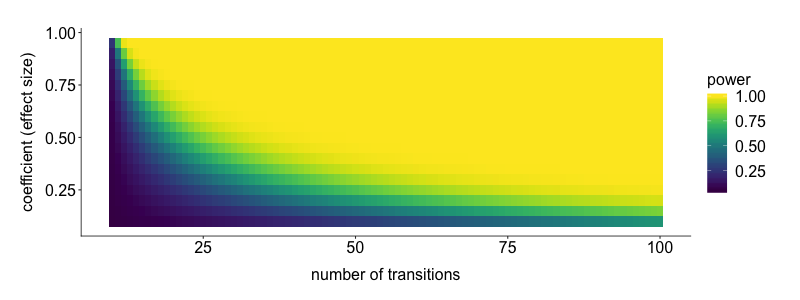

In [150]:
%%R -w 800 -h 300 -u px -i power_df,figure_name  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

p <- ggplot(data=power_df, aes(x=sample_size, y=effect_size)) + 
    stat_density_2d(geom = "polygon") +
    geom_tile(aes(fill = power)) +
    scale_fill_viridis()+
#     geom_smooth(method='lm',formula=y~x, color = "black", se=FALSE)+
#     scale_x_continuous(limits=c(2008, 2018), breaks=c(2008,2010,2012,2014,2016,2018))+ 
#     scale_y_continuous(limits=c(0,0.3))+
    labs(x="number of transitions",y="coefficient (effect size)")+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=116))+
    theme(axis.title.y=element_text(size=16, vjust=4))+
    theme(axis.title.x=element_text(size=16, vjust=-3))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave(figure_name, p, width = 5, height = 3.5, path="/Users/lmoncla/Documents/Fellowships/K99/resubmission/figures/")
p